# k-means

## Goals:

1. Determine the optimal number of clusters using elbow method and clustering metrics (davies, calinski) 
2. Using tf-idf feature representation and pca as a dimensionality reduction tool
3. Examine the characterics of each cluster
4. Use PCA representation to build a scatter plot of optimal k-clusters

In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [106]:
# import data
cleaned = pd.read_pickle('data/features.pkl')

In [3]:
cleaned.head()

,original_text,label,preprocessed,word_count,avg_word_count,syllable_count,uncommon,difficult_words,stem,discourse,cohesive_features,flesch,dale,mcalpine,nouns_adjs,normalized
0,There is manuscript evidence that Austen conti...,1,"[there, is, manuscript, evidence, that, austen...",35,4.485714,1.371429,14,7,there is manuscript evid that austen continu t...,4,2,52.87,11.24,48.0,0.228571,there is manuscript evidence that austen conti...
1,"In a remarkable comparative analysis , Mandaea...",1,"[in, a, remarkable, comparative, analysis, man...",19,6.000000,1.789474,14,8,there is manuscript evid that austen continu t...,2,1,35.27,14.55,23.0,0.315789,in a remarkable comparative analysis mandaean ...
2,"Before Persephone was released to Hermes , who...",1,"[before, persephone, was, released, to, hermes...",40,4.725000,1.400000,15,9,there is manuscript evid that austen continu t...,7,3,47.80,11.15,57.0,0.175000,before persephone was released to hermes who h...
3,Cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",32,6.281250,1.781250,22,14,there is manuscript evid that austen continu t...,0,1,22.08,14.60,38.0,0.593750,cogeneration plants are commonly found in dist...
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[geneva, is, the, city, in, switzerland, after...",20,4.650000,1.350000,7,4,there is manuscript evid that austen continu t...,0,2,68.10,8.58,29.0,0.400000,geneva is the city in switzerland after zürich...


### Step 1:

Here, we will apply k-means clustering to a set of text documents to gain some insight into the nature of the content. 

This scenario uses the TfidfVectorizer class to convert each text to a numeric vector. 

In [107]:
def vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """   
    df = pd.read_pickle('data/features.pkl')['normalized']
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 min_df=2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [108]:
vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Dimentionality reduction using PCA - used for plotting

Let's build a function that takes the various numerical vectors and reduces them into two principle componments

In [109]:
def pca(npca_components):
    """
    Reduces dimensions of text into PCA space
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    X, vectorizer, review_instances = vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)
    
    # convert vectorized text into dataframe 
    df_x_tdidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    
    #Reduce TFIDF features X
    X_pca = PCA(n_components=npca_components).fit_transform(StandardScaler().fit_transform(df_x_tdidf))
    
    # convert pca features to dataframe:
    df_xpca = pd.DataFrame(X_pca, columns = ["pca"+str(i) for i in range(1, npca_components+1)])
    
    return df_xpca


In [60]:
#df_pca = pca(2)

In [111]:
df_pca.to_pickle("data/pca2.pkl")

In [112]:
# load pca dataframe
pca_df = pd.read_pickle("data/pca2 2.pkl")

In [113]:
pca_df.head()

,pca1,pca2
0,-0.646257,0.175473
1,-0.473542,0.115037
2,-0.615671,0.160943
3,-0.527799,0.128182
4,-0.402762,0.024076


# Finding the optimal number of clusters

#### K-Means: Elbow Method

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.

To find the optimal K for a dataset we use the Elbow method. The optimal K is the point where the decrease in inertia begins to slow (looks like an elbow)

In [114]:
# first let's try with a sample
df = pd.read_pickle('data/features.pkl')
sample= df['normalized']

sample

0         there is manuscript evidence that austen conti...
1         in a remarkable comparative analysis mandaean ...
2         before persephone was released to hermes who h...
3         cogeneration plants are commonly found in dist...
4         geneva is the city in switzerland after zürich...
                                ...                        
416763    a duke nukem version has been sold for xbox li...
416764    however it is becoming replaced as a method of...
416765    there are hand gestures in both hindu and budd...
416766    if it is necessary to use colors try to choose...
416767                                   calgary stampeders
Name: normalized, Length: 403608, dtype: object

In [115]:
sample.shape

(403608,)

In [116]:
def vectorized_sample(top_n = -1, ngram_range = (1,2), max_features = 200):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """
    df = sample
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 min_df=2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [54]:
inertia = []
labels = []

def elbow_method():
    """Returns optimal k_clusters in the range of 2 to 10"""
    X, vectorizer, review_instances = vectorized_sample(top_n = -1, ngram_range = (1,2), max_features = 200)

    for k in tqdm(range(2, 15)): 
        km = KMeans(n_clusters=k, max_iter=50,random_state=42).fit(X.toarray())
        labels.append(km.labels_)
        inertia.append(km.inertia_)
    return labels, inertia

In [55]:
elbow_method()

100%|██████████| 13/13 [01:37<00:00,  7.52s/it]


([array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
  array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
  array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
  array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([5, 5, 5, ..., 5, 5, 5], dtype=int32),
  array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
  array([5, 5, 4, ..., 5, 5, 5], dtype=int32),
  array([5, 5, 5, ..., 5, 5, 5], dtype=int32),
  array([ 0,  0,  0, ...,  0, 10,  0], dtype=int32),
  array([2, 2, 5, ..., 2, 0, 2], dtype=int32),
  array([4, 4, 4, ..., 4, 4, 4], dtype=int32)],
 [308467.9920745839,
  303154.42636353546,
  300350.1517501618,
  298999.9948782781,
  292470.0638872647,
  292378.48869459436,
  290249.6551985713,
  286553.3621109937,
  286184.7318245077,
  281493.2527316093,
  278759.4946151692,
  279263.89275810885,
  277439.484919382])

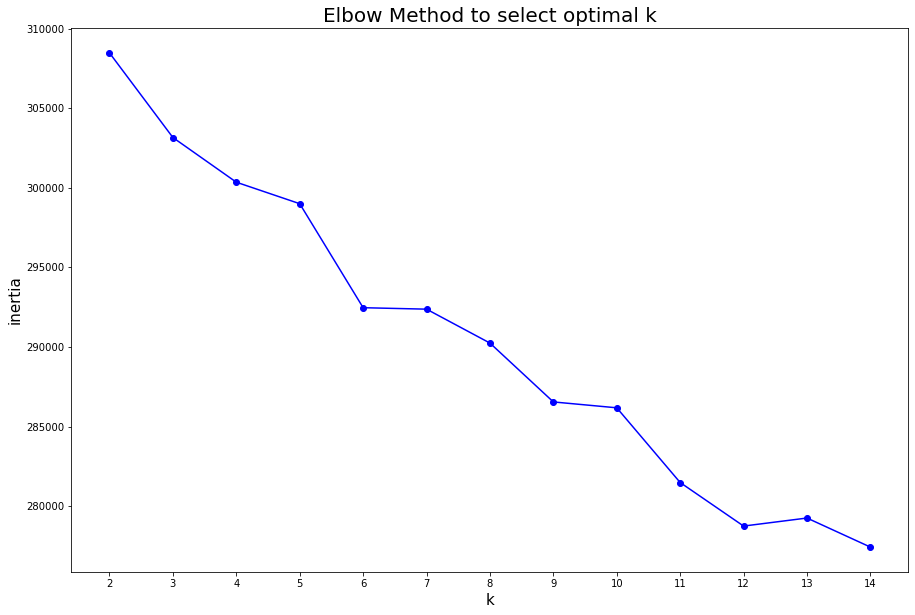

In [97]:
# Elbow Plot: 
plot = plt.figure(figsize= (15,10))
plot = plt.plot(range(2,15), inertia,'o-', color = 'blue')
plot= plt.xticks(list(range(2,15)))
plot= plt.xlabel('k',fontsize=15)
plot= plt.ylabel('inertia',fontsize=15)
plot= plt.title('Elbow Method to select optimal k',fontsize=20)

# Davies-Bouldin method for selecting optimal k (lower is better)

In [57]:
def clusters():
    """
    We're looking for clusterings that have a high Calinski-Harabasz index
    but a low Davies-Bouldin score.
    """
    from sklearn.cluster import KMeans
    from sklearn import metrics
    from sklearn.metrics import pairwise_distances
    
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)

    metric_values = []
    for i in tqdm(range(2,13)):
        kmeans_model = KMeans(n_clusters = i, init='k-means++', max_iter=50,n_init=1, random_state=42)
        kmeans_model.fit(X.toarray()) 
        labels = kmeans_model.labels_
        calinkski = metrics.calinski_harabasz_score(X.toarray(), labels) #The score is higher when clusters are dense 
       # and well separated, which relates to a standard concept of a cluster.

        davies = metrics.davies_bouldin_score(X.toarray(), labels) #lower values indicating better clustering.
        metric_values.append((i,calinkski,davies))
    return metric_values

In [58]:
clusters()
# seems that 8 clusters is the optimal number of clusters

100%|██████████| 11/11 [00:42<00:00,  3.84s/it]


[(2, 3671.8182137916247, 2.970708243992744),
 (3, 3546.741184358633, 3.37378202919894),
 (4, 3054.6042494098906, 3.0136976822247132),
 (5, 2904.6196387561668, 2.8304107267717415),
 (6, 4659.445179487839, 2.66195899131375),
 (7, 4173.626067110101, 2.6136996988536105),
 (8, 5237.450016374175, 2.562283796796833),
 (9, 4750.7935811059715, 2.4483308866437943),
 (10, 4459.725407528888, 2.4335196256840765),
 (11, 4285.744349500346, 2.4367865283616097),
 (12, 4331.613574944948, 2.4462039552903563)]

In [103]:
# clu=[(2, 3671.8182137916247, 2.970708243992744),
#  (3, 3546.741184358633, 3.37378202919894),
#  (4, 3054.6042494098906, 3.0136976822247132),
#  (5, 2904.6196387561668, 2.8304107267717415),
#  (6, 4659.445179487839, 2.66195899131375),
#  (7, 4173.626067110101, 2.6136996988536105),
#  (8, 5237.450016374175, 2.562283796796833),
#  (9, 4750.7935811059715, 2.4483308866437943),
#  (10, 4459.725407528888, 2.4335196256840765),
#  (11, 4285.744349500346, 2.4367865283616097),
#  (12, 4331.613574944948, 2.4462039552903563)]
# davies=[]
# for c in clu:
#     davies.append(c[2])

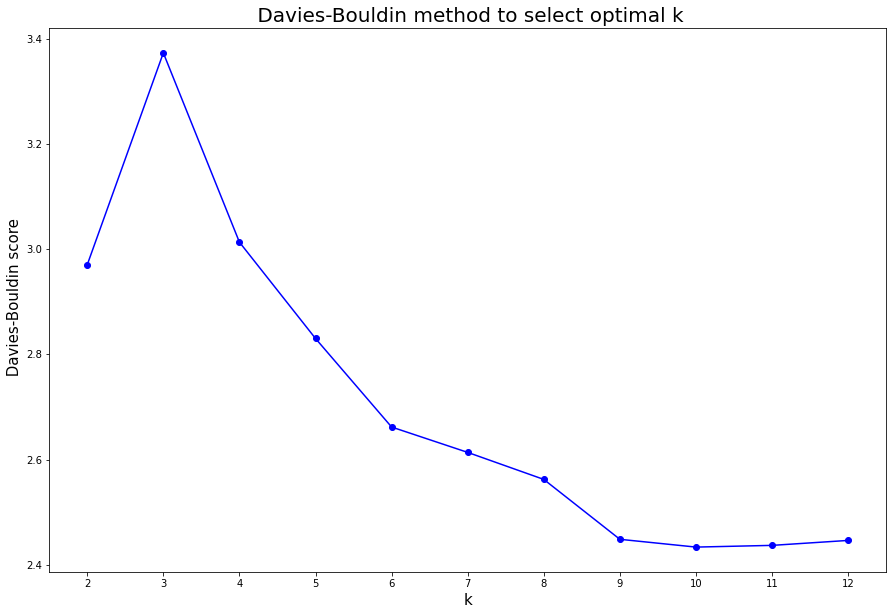

In [104]:
plot = plt.figure(figsize= (15,10))
plot = plt.plot(range(2,13), davies,'o-', color = 'blue')
plot= plt.xticks(list(range(2,13)))
plot= plt.xlabel('k',fontsize=15)
plot= plt.ylabel(' Davies-Bouldin score',fontsize=15)
plot= plt.title(' Davies-Bouldin method to select optimal k',fontsize=20)

# Silhouette score (higher in better)

In [59]:
# Calculate silhouette_score 
def silhouette():
    sil_score={}
    # Calculate silhouette_score: (Optional- On a smaller sample size. This should be highest)
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)
    for k in tqdm(range(2,15)): 
        km_optimal = KMeans(n_clusters=k, max_iter=100, n_init=1, init='k-means++', random_state=0).fit(X)
        sil_score[k] = silhouette_score(X, km_optimal.labels_, sample_size= 100000, random_state = 0)
    return sil_score

In [60]:
silhouette()

100%|██████████| 13/13 [55:27<00:00, 255.99s/it]


{2: 0.0946893010461914,
 3: 0.09819948800808777,
 4: 0.10436234700799296,
 5: 0.10571447155684026,
 6: 0.10907138457712015,
 7: 0.11279711858493707,
 8: 0.11079206283009298,
 9: 0.11130390450417398,
 10: 0.11279968372028933,
 11: 0.11568555040094711,
 12: 0.1173028966786146,
 13: 0.12021214588466897,
 14: 0.1326428271520573}

In [80]:
df_sil= pd.DataFrame(sil, index=(range(0,13)))

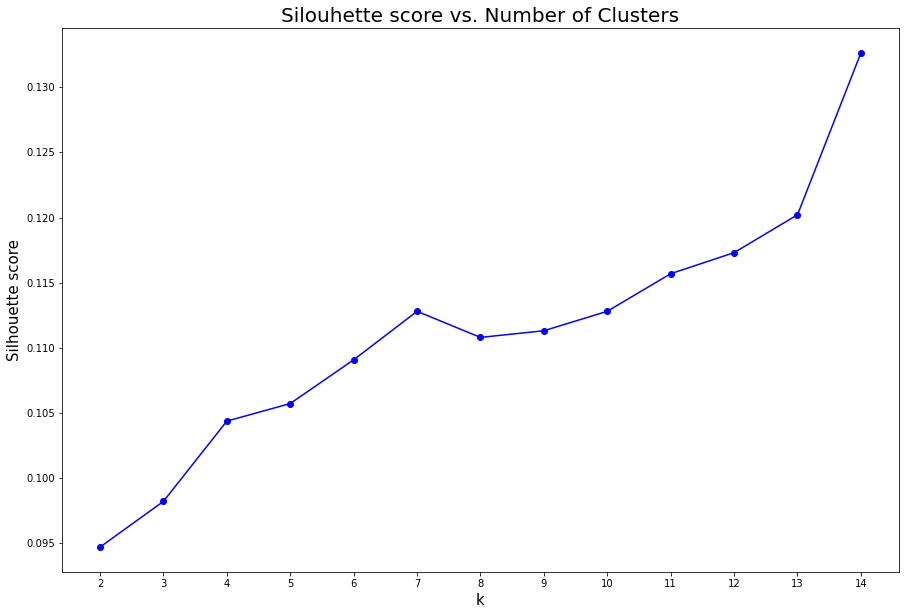

In [98]:
pl = plt.figure(figsize= (15,10))
pl =plt.plot(range(2,15),df_sil.iloc[0],'o-',color ='blue')
pl= plt.xticks(list(range(2,15)))
pl= plt.xlabel('k',fontsize=15)
pl= plt.ylabel('Silhouette score',fontsize=15)
pl= plt.title('Silouhette score vs. Number of Clusters',fontsize=20)

# WordCloud for clusters

In [130]:
def wordcloud():
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    X, vectorizer, review_instances = vectorized_sample(top_n = -1, ngram_range = (1,2), max_features = 200)
    kmeans_model= KMeans(n_clusters=10, max_iter=50,random_state=42).fit(X.toarray())
    labels = kmeans_model.labels_
    original_text = df['normalized']
    result = {'cluster':labels, 'article_text':original_text}
    result = pd.DataFrame(result)
    for k in range(0,10):
        s = result[result.cluster==k]
        text = s['article_text'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        #print('Cluster: {}'.format(k))
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
    return plt.show()

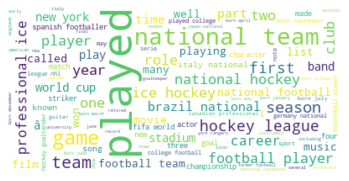

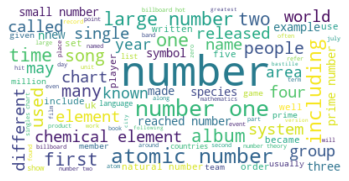

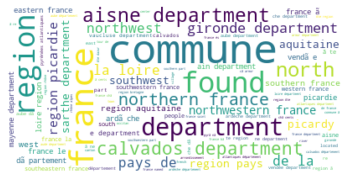

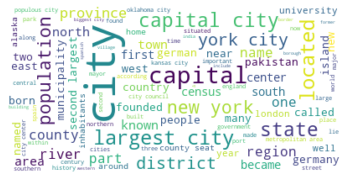

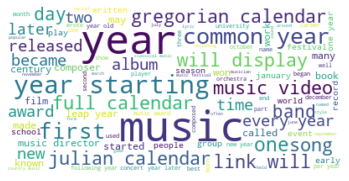

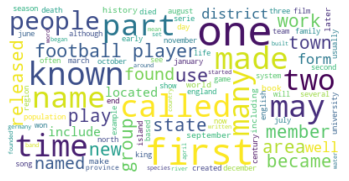

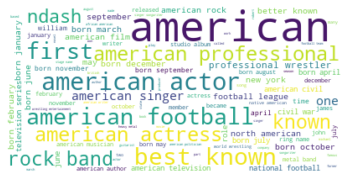

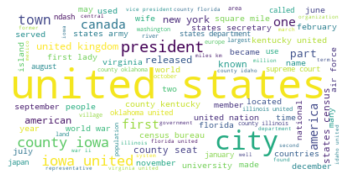

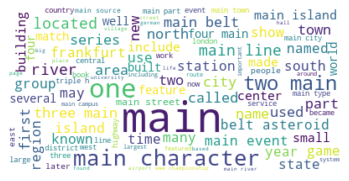

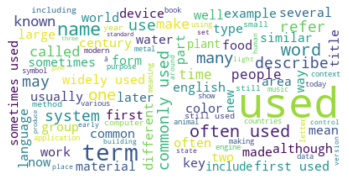

In [131]:
wordcloud()

##  Predominant terms in the resulting clusters

Each cluster is a collection of vectors, each of which represents a documents from Wikipedia. To find good *representative terms* for each cluster, we want to know what the "typical" document looks like for each of the K clusters. A "typical" document for a cluster is just the mean of all the vectors (documents) that belong to that cluster. This vector is known as the cluster centroid or center.

To get the most predominant terms in a vector, we just sort the entries of the cluster centroid from highest to lowest term weight, and return the corresponding term strings

In [122]:
def kmeans_clusters():
    """
    Returns a list that has k elements, where k is the optimal number of clusters
    Each of these k elements contains a list of the top 10 terms (strings) for that cluster. 
    These terms are sorted by highest to lowest term weight value as stored in the cluster centroid.
    """
    kmeans=KMeans(n_clusters=10,init='k-means++',max_iter=100,n_init=1,random_state=42)
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)
    
    kmeans.fit(X)
    
    centroids=kmeans.cluster_centers_
    columns=vectorizer.get_feature_names()
    centers = [list(zip(columns,center)) for center in centroids]
    sorted_words = [sorted(each,key=lambda x:x[1],reverse=True)[:10]for each in centers]
    result=[[tup[0] for tup in each] for each in sorted_words]
  
    return result

In [123]:
kmeans_clusters()

[['important',
  'example',
  'century',
  'people',
  'called',
  'time',
  'number',
  'known',
  'like',
  'use'],
 ['born',
  'player',
  'football',
  'football player',
  'american',
  'japanese',
  'plays',
  'january',
  'april',
  'july'],
 ['known',
  'city',
  'called',
  'new',
  'world',
  'people',
  'time',
  'american',
  'years',
  'state'],
 ['used',
  'term',
  'called',
  'word',
  'make',
  'known',
  'usually',
  'use',
  'people',
  'different'],
 ['work',
  'known',
  'best',
  'people',
  'published',
  'did',
  'began',
  'time',
  'early',
  'new'],
 ['aisne',
  'department',
  'france',
  'commune',
  'northern',
  'north',
  'region',
  'la',
  'following',
  'french'],
 ['government',
  'state',
  'new',
  'district',
  'city',
  'party',
  'british',
  'german',
  'national',
  'people'],
 ['states',
  'united',
  'united states',
  'city',
  'county',
  'president',
  'state',
  'kingdom',
  'new',
  'town'],
 ['france',
  'commune',
  'department',
  'r

Let's play around with values for the parameters of TfidfVectorizer, to see how the results change, because the results of this kind of clustering can be very sensitive to those parameters, which control how the text is processed, what defines what a "term" is, and which words are kept as features in the clustering.

In [124]:
def vectorized_diffvalues(top_n = -1, ngram_range = (2,3), max_features = 1000):
    """
    This function returns:
    - a matrix X with one row per document (review). Each row is a sparse
    vector containing tf.idf term weights for the words in the document.
    """
    df = sample
    vectorizer = TfidfVectorizer(max_features=max_features, max_df= 0.5,
                                 min_df= 2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        instances = df.values[0:top_n]
    else:
        instances = df.values
    
    X = vectorizer.fit_transform(instances) 
    
    return (X, vectorizer, instances)

In [128]:
def kmeans_clusters_experiment():
    """
    Returns a list that has k elements, where k is the optimal number of clusters
    Each of these k elements contains a list of the top 10 terms (strings) for that cluster. 
    These terms are sorted by highest to lowest term weight value as stored in the cluster centroid.
    """
    X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (2,3), max_features = 1000)
    kmeans=KMeans(n_clusters=10,init='k-means++',max_iter=100,n_init=1,random_state=42)

    
    kmeans.fit(X)
    
    centroids=kmeans.cluster_centers_
    columns=vectorizer.get_feature_names()
    centers = [list(zip(columns,center)) for center in centroids]
    sorted_words = [sorted(each,key=lambda x:x[1],reverse=True)[:10]for each in centers]
    result=[[tup[0] for tup in each] for each in sorted_words]
  
    return result

In [129]:
kmeans_clusters_experiment()

[['united states',
  'best known',
  'world war',
  'department region',
  'prime minister',
  'north america',
  'commune department',
  'region france',
  'national team',
  'high school'],
 ['new york',
  'new york city',
  'york city',
  'united states',
  'new york times',
  'york times',
  'new jersey',
  'los angeles',
  'university press',
  'symphony orchestra'],
 ['commune gironde department',
  'commune gironde',
  'gironde department',
  'department aquitaine',
  'gironde department aquitaine',
  'department aquitaine france',
  'aquitaine france',
  'aquitaine southwestern',
  'aquitaine southwestern france',
  'department aquitaine southwestern'],
 ['region department north',
  'region department',
  'department north france',
  'department north',
  'north france',
  'commune region department',
  'commune region',
  'aisne department north',
  'aisne department',
  'la commune'],
 ['united states',
  'interstate highway',
  'supreme court',
  'house representatives',
  

### Information Gain for discriminative clusters

Ideally, we'd like to find slighly better representative words for each cluster that are somewhat *specific* to that cluster and not others, i.e. words that distinguish documents in that cluster from documents in other clusters. To use the technical term, we want terms that are *discriminative* with respect to the clusters, not just descriptive. We will make use of Infomration gain to help us come up with such clusters

In [140]:
from scipy.stats import entropy

def compute_distinctive_term_score(T, T_a):   
    # First compute information gain.
    IG = entropy(T) - entropy(T_a) 
    #if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms whose *absence* is notable, 
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    
    if (T_a[0] < T_a[1]):
        score = -IG  
    else:
        score = IG
    return score

# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index+1:, :])).sum(axis=0)
    result = np.vstack((row0, row1))
    return result

def cluster_labeling():
    kmeans=KMeans(n_clusters=10,init='k-means++',max_iter=100,n_init=1,random_state=42)
    X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (1,2), max_features = 1000)
    kmeans.fit(X)
    centroids=kmeans.cluster_centers_
    centroids=np.array(centroids) #This should be an array with seven (7) rows, one row per cluster, 
    #and 1000 columns (one column per word/term in the vocabulary produced by the vectorizer).
    final = []
    
    for i in range(centroids.shape[0]):
        
        ctm = one_vs_all_count_matrix(centroids,i)#the first row has the weights of words in this cluster 𝑐  
        #(which is the same as L[c, :]), and the second row has the aggregate summed weights of the words 
        #across all other clusters. The columns are the same as  𝐿 : one column per term in the vocabulary.
        T_c = ctm.sum(axis=1)
        T_c = T_c/sum(T_c)
        result = []
        for i in range(centroids.shape[1]):
            T_w=ctm[:,i]
            T_w=T_w/sum(T_w)
            info_gain = compute_distinctive_term_score(T_c, T_w)
            result.append(info_gain)
            
        terms_score=list(zip(vectorizer.get_feature_names(),result))
        terms_score=sorted(terms_score,key=lambda x:x[1],reverse=True)[:10]
        terms_score=[each[0] for each in terms_score]
        final.append(terms_score)
    return final

cluster_labeling()

[['mainly',
  'related',
  'services',
  'natural',
  'higher',
  'true',
  'planet',
  'jesus',
  'theory',
  'change'],
 ['saint',
  'smaller',
  'nation',
  'sound',
  'dutch',
  'zealand',
  'new zealand',
  'mario',
  'commune department',
  'van'],
 ['went',
  'ended',
  'soon',
  'professional',
  'boy',
  'paul',
  'directed',
  'open',
  'announced',
  'festival'],
 ['thomas',
  'mary',
  'born october',
  'born august',
  'academy',
  'usa',
  'national football',
  'nobel',
  'west',
  'william'],
 ['conductor',
  'complete',
  'object',
  'wrestling',
  'development',
  'create',
  'raw',
  'network',
  'project',
  'episode'],
 ['lake',
  'mountains',
  'wales',
  'pakistan',
  'right',
  'district',
  'km',
  'historical',
  'cross',
  'castle'],
 ['austria',
  'hockey',
  'switzerland',
  'heat',
  'hockey league',
  'edition',
  'champion',
  'berlin',
  'national team',
  'sun'],
 ['iowa united',
  'united kingdom',
  'seat',
  'city',
  'brand',
  'fox',
  'county',
 

### Visualization

In [134]:
# scatter plot using optimal clusters
tokens = {}
def optimal_k(num = 200, k = 10):
    #X, vectorizer, instances = vectorized_diffvalues(top_n = -1, ngram_range = (1,2), max_features = 1000)
    X, vectorizer, review_instances = vectorized_sample(ngram_range = (1,2), max_features = 200)
    k_best = KMeans(n_clusters=k, max_iter=100, n_init=1, init='k-means++', random_state=42).fit(X)
    
    # Get cluster centers: 
    cluster_center = pd.DataFrame(k_best.cluster_centers_, columns = vectorizer.get_feature_names()).T
    
    for i in cluster_center.columns: 
    
        tokens[i] = cluster_center[i].sort_values(ascending = False)[:num].index
        
    central_words = pd.DataFrame(tokens)
    central_words.columns = ["cluster_"+str(i) for i in range(1, k+1)]
    return k_best, central_words

In [135]:
k_best, central_words = optimal_k(num = 200, k = 10)

In [136]:
X= vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)[0]
vectorizer= vectorized(top_n = -1, ngram_range = (1,2), max_features = 2000)[1]

In [137]:
df_x_tdif = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
df_x_tdif.head()

,aargau,abbey,abbottabad,abbreviated,ability,able,academy,accepted,access,according,...,years old,yellow,york,york city,yorkshire,young,younger,youth,zealand,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.36234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(df_x_tdif)

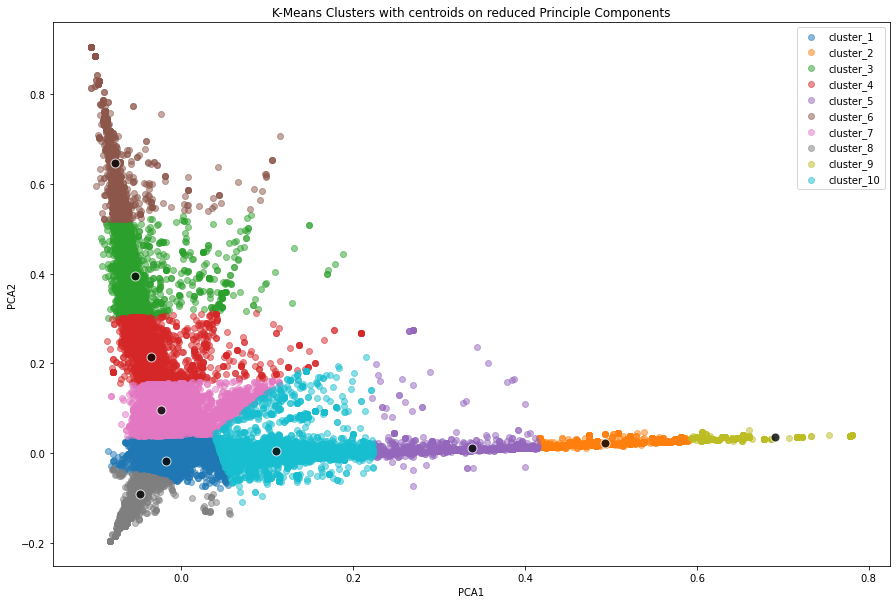

In [139]:
# Get unique labels: 
label = k_best.fit_predict(X_pca)
u_labels = np.unique(label)

f = plt.figure(figsize= (15,10))
for i in u_labels: 
    f = plt.scatter(x = X_pca[label == i , 0] , y = X_pca[label == i , 1] , label = "cluster_"+str(i+1), \
                    cmap=plt.get_cmap('viridis'), alpha = 0.5)
    f = plt.xlabel('PCA1')
    f = plt.ylabel('PCA2')
    f = plt.title('K-Means Clusters with centroids on reduced Principle Components')
    f = plt.legend()

for i in k_best.cluster_centers_:  
    f= plt.scatter(x = i[0],y = i[1],  s = 80, marker='o', label = "cluster_"+str(i+1),\
                    c= 'black', edgecolors='white', alpha = 0.8)
plt.savefig('figures/k-means.png')